In this notebook we will demonstrate the use of the `TableAutomization.py` file to compare the performance of selected samplers on this distribution

 __The Aim__:
- allow sampling with different sampling methods at the same time 
- compare these sampling methods in terms of different parameters 
- visualize the distribution (in case of 2D and 1D)


__The Sampling Methods__:
So far the sampling methods implemented are
- (Random Walk) Metropolis Hastings (component wise or not): __MH__ or __CWMH__
- Unadjusted Langevin algorithm: __ULA__
- Metropolis-adjusted Langevin algorithm: __MALA__
- No-U-Turn Sampler: __NUTS__


Note: we also have the otion of passing these as adapted functions: for examples, __MH_adapted__ meaning that when creating the plot the burnins will not be shown


__The inputs__: 
The user has to provide just a few parameters used for the sampling methods:
- __target__:
 The target distribution to sample. Must have logpdf and gradient method. Custom logpdfs and gradients are supported by using a cuqi.distribution.UserDefinedDistribution.

- __scale__ (float): 
    - __MH__: Scale parameter used to define correlation between previous and proposed sample in random-walk.
    - __ULA__: The Langevin diffusion discretization time step (In practice, a scale of 1/dim**2 is recommended but not guaranteed to be the optimal choice)
    - __MALA__:  The Langevin diffusion discretization time step.
    - __NUTS__: no scale needed 

- __Ns__ (int): used for sampling, number of samples needed 
- __Nb__ (int): used for sampling, number of samples burned 

- __x0__ (numpy array or distribution): The intial sampling point (If it is a distibution,you randomly sample one point from the distribution)
- __seed__(int): random seed 
- __chains__(int): used for calculating Rhat, number of chains
- __selected_criteria__ (list of strings): user can choose the desired criteria for comparing the methods 
- __selected_methods__ (list of strings): user can choose the sampling methods that are gonna be compared

_NOTE_: 
- the three parameters above (__scale__, __Ns__, __Nb__) can be either scalars (the same for all sampling methods) or arrays of 5 elements (particular for each sampling method) and the parameter(__x0__) can be eithe numpy array or CUQI distribution object.
- not all parameters are mandatory for calling the function:
    - dim = 2,
    - x0 = None
    - seed = None
    - chains = 2
    - selected_criteria= ["ESS", "AR", "LogPDF", "Gradient","Rhat"]
    - selected_methods =["MH_fixed", "CWMH", "ULA", "MALA", "NUTS"]

__The outputs__:
- __ESS__: Compute effective sample size (ESS) of sample in 2 dimensions
- __AR__: compute acceptance rate
- __Rhat__: Compute estimate of rank normalized splitR-hat for a set of traces in 2 dimensions

    _Note_: Rhat is computed only when chains > 1
- __LogPDF__: with `cProfile` we compute how many time `logpdf` is computed, hence can see the computational costs clearer
- __Gradient__: with `cProfile` we compute how many time `gradient` is computed, hence can see the computational costs clearer



__Some Refrences__:
- [CUQI-BOOk](https://cuqi-dtu.github.io/CUQI-Book/chapter03/gradient_based_sampling_with_cuqipy.html)
- [ArviZ API reference](https://python.arviz.org/en/stable/api/diagnostics.html)

### Importing the needed libraries 

In [1]:
import cuqi
import numpy as np
import os
import sys
sys.path.append(os.path.abspath('..'))
import utilities as ut
import benchmarksClass as BC 
from utilities import Plot

# The donut distribution


In [2]:
target_donut = BC.Donut()

### Plotting the "donut"

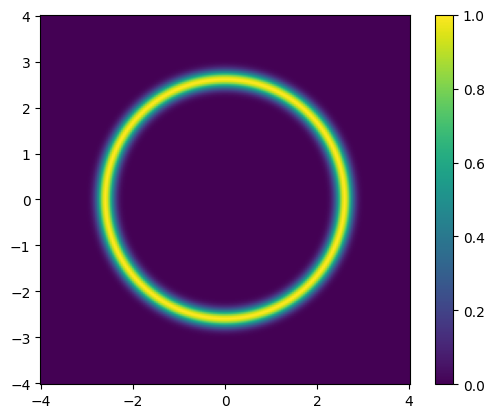

In [3]:
a = Plot(target_donut)
a.plot_pdf_2D( -4, 4, -4, 4)

## 1. First Example 

The purpose of this example is to see the behaviour of __bad__ and __good__ sampling methods, __complex__ and not so complex computational methods 


- Compute sampling methods with the followig parameters

1. __MH_fixed__ : scale = 0.05, Ns = 10000, Nb = 0
2. __CWMH__:  scale = 0.05, Ns = 8500, Nb = 1500
3.  __ULA__: scale = 0.065, Ns = 10000, Nb = 0
4.  __MALA__: scale = 0.065, Ns = 10000, Nb = 5000
5. __NUTS__: scale = 0.05, Ns = 1000, Nb = 100


In [4]:
samples = ut.MCMCComparison(target_donut, 
    [0.05, 0.05, 0.065, 0.065, 0.05 ], 
    [10000, 8500, 10000, 10000, 1000], 
    [0, 1500, 0, 5000, 100], 
    x0 = np.array([1, 1]),
    seed=12)

In [5]:
df = samples.create_comparison()

/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")


- Print the samples diagnostics in a tabular format

In [6]:
df

,MH,CWMH,ULA,MALA,NUTS
samples,10000,8500,10000,10000,1000
burnins,0,1500,0,5000,100
scale,0.05,0.05,0.065,0.065,-
ESS(v0),1.318,10000.0,59.472,14.883,9.901
ESS(v1),3.18,10000.0,37.963,4.492,13.935
AR,0.876,0.0,1.0,0.506,0.533
LogPDF,10002,20002,10002,15002,6292
Gradient,0,0,10002,15002,6292
LogPDF/ESS,4447.497,2.0,205.307,1548.661,527.945
Gradient/ESS,0.0,0.0,205.307,1548.661,527.945



_Observations_
- The MH_fixed is a bad sampling method in this: ESS is low and the AR is too high (the samples are somewhat corrrelated)
- the CWMH is still not great, however, one can see the improvement in the ESS value, which might be due to adapting the scale to a higher one. 
- Neither of these use gradient, thus the number of computed Gradients is 0
- the ULA method shows a good ESS and an accceptence rate of 1.0, this is expected since ULA does not have the choice of declining a step
- NUTS: significantly outperforms other methods; however, it can clearly be seen that it has the by far the highest computational costs out of all methods, even though it has significantly less samples

- Now we will take a look at the samples of each method plotted onto the "donut" distribution graphs

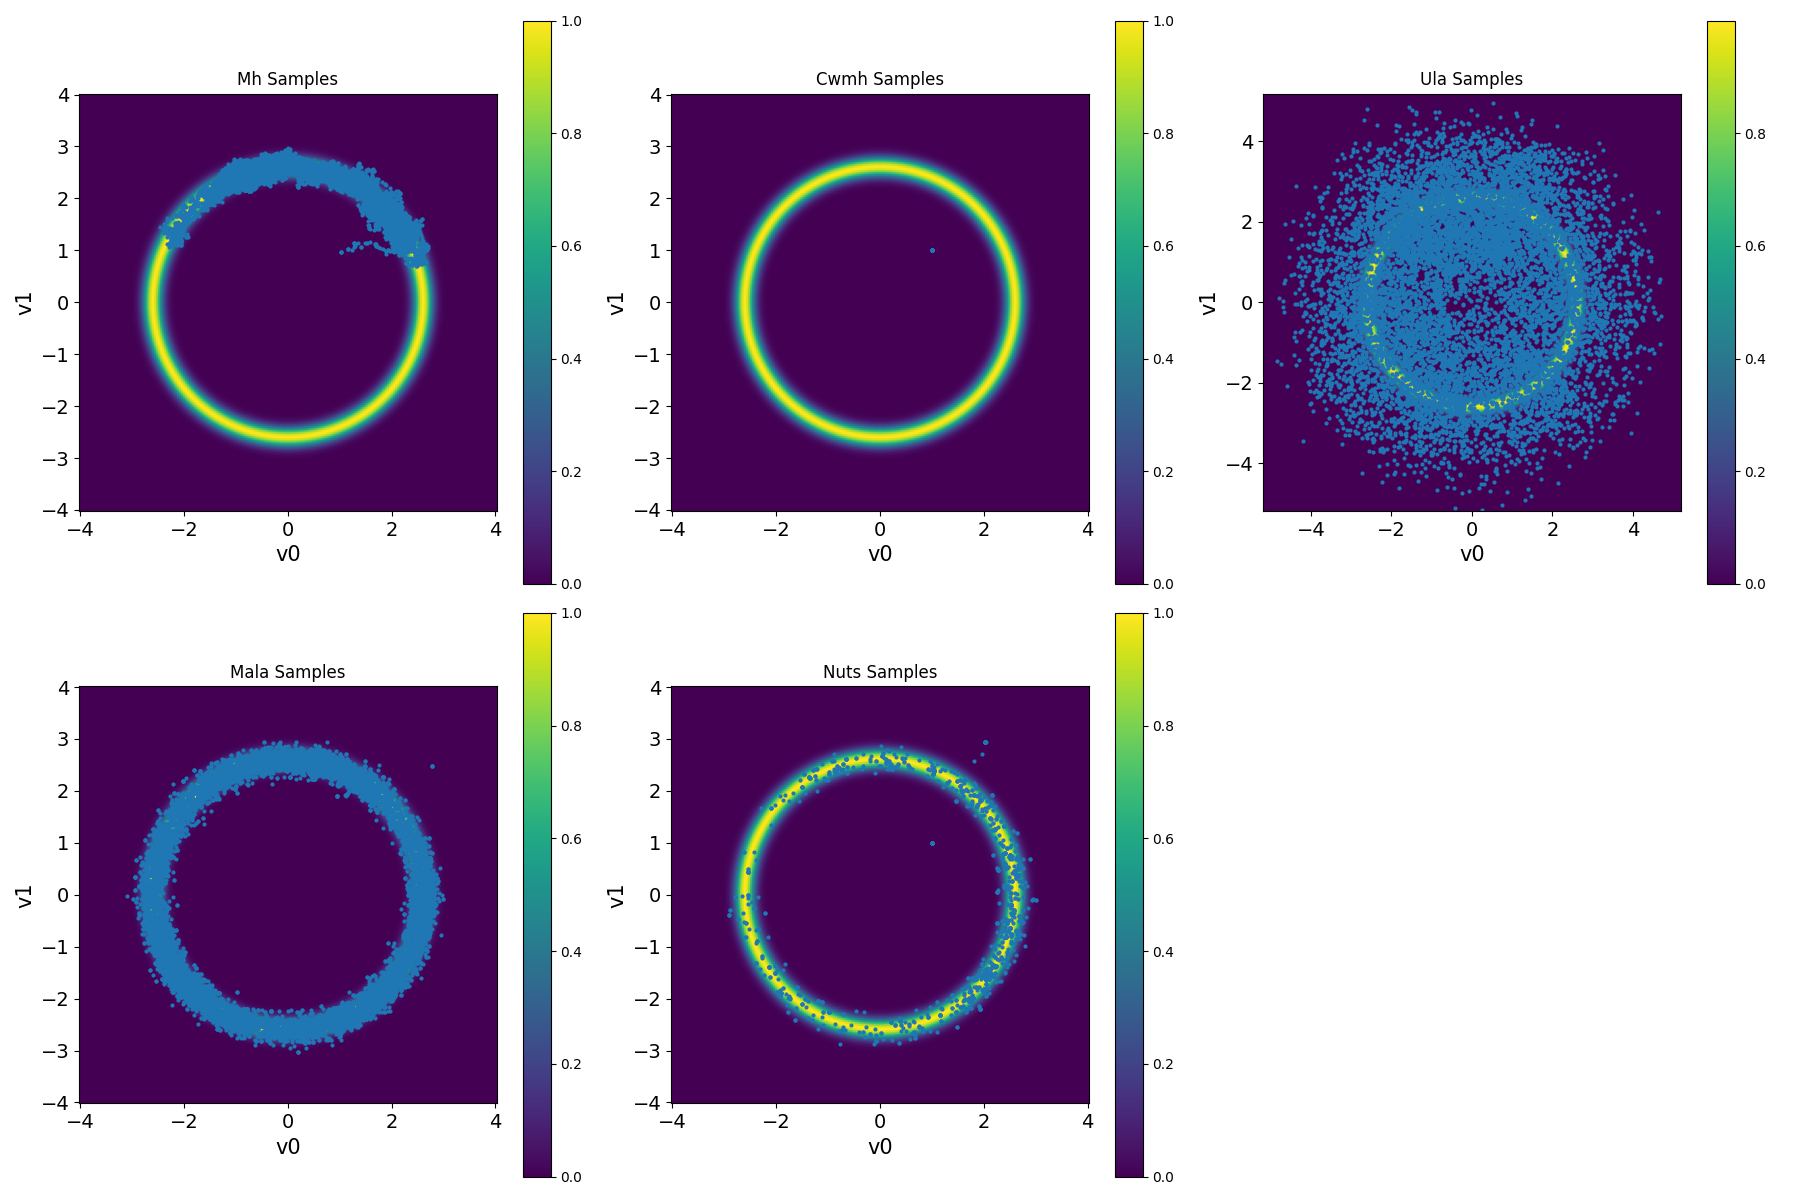

(<Figure size 1800x1200 with 10 Axes>,
 array([<Axes: title={'center': 'Mh Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: title={'center': 'Cwmh Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: title={'center': 'Ula Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: title={'center': 'Mala Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: title={'center': 'Nuts Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: >], dtype=object))

In [7]:
samples.create_plt()

_Observations_
- as expected the MH_fixed and CWMH does not stray far away from the initial point 
- ULA plot shows clearly the lack of rejection in the algorithm 
- both MALA and NUTS provide quite a somewhat accurate sample representation 

## 2. Second example
In this example, the sampling of x0 is from an initial dstribution, and we try to tune the scales for each of the selected methods.
We start by using the same number of samples, burnins and the same scale for each method: 
- scale = 0.05
- Ns = 8500
- Nb = 1500

- Compute sampling methods

In [8]:
true_mu = np.array([0, 0])
true_sigma = np.array([1,1])
y = cuqi.distribution.Gaussian(mean=true_mu, cov=true_sigma**2)

In [9]:
samples = ut.MCMCComparison(target_donut, 0.05, 8500, 1500, x0 = y, seed = 12,chains=2)

In [10]:
df = samples.create_comparison()

/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")
/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")


- Print table

In [11]:
df

,MH,CWMH,ULA,MALA,NUTS
samples,8500,8500,8500,8500,8500
burnins,1500,1500,1500,1500,1500
scale,0.05,0.05,0.05,0.05,-
ESS(v0),8.757,21.207,27.633,27.522,434.764
ESS(v1),16.632,28.525,26.65,16.985,1919.481
AR,0.409,0.565,1.0,0.63,0.585
LogPDF,10002,20002,10002,10002,174768
Gradient,0,0,10002,10002,174768
Rhat(v0),1.078,1.013,1.034,1.016,1.001
Rhat(v1),1.108,1.029,1.005,1.02,1.003


_Observations_
- It can be seen base on the parameters ESS and AR that MH preformes quite poorly. On the other hand, a pro of MH is the low computational costs 
- ULA has acceptence rate AR=1, as expected, and it performs decently, with ESS parameters not too high but higher than MH, also R_hat is close to 1, meaing that it converges well enough
- MALA performs decently, but once again it can be seen that NUTS outperforms the other algotithms by far, based on the Rhat and ESS values; however the costs are also way higher compared to the other algorithms. 

- Now we will take a look at the samples of each method plotted onto the "donut" distribution graphs

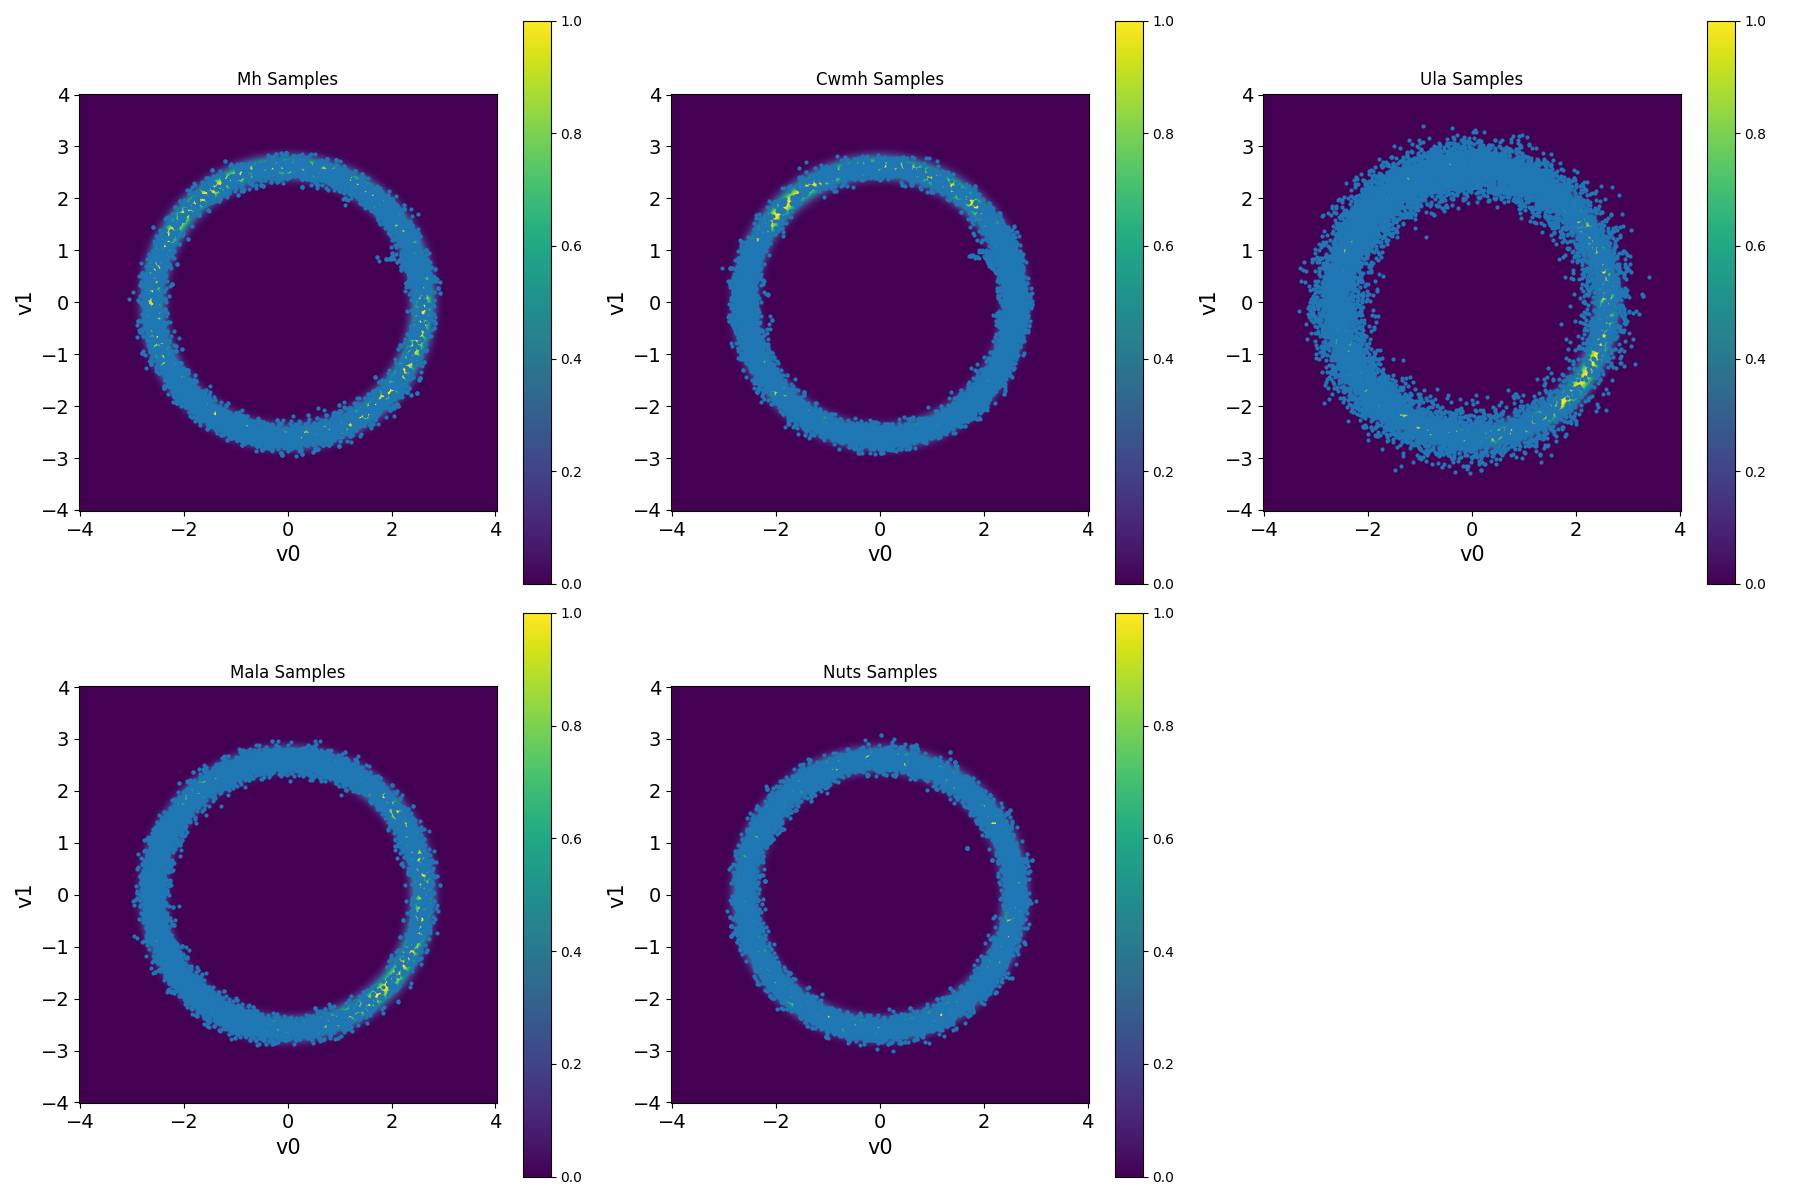

(<Figure size 1800x1200 with 10 Axes>,
 array([<Axes: title={'center': 'Mh Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: title={'center': 'Cwmh Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: title={'center': 'Ula Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: title={'center': 'Mala Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: title={'center': 'Nuts Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: >], dtype=object))

In [12]:
samples.create_plt()

_Observations_
- once again the MH methods do not stray away from the initial point
- both MALA and NUTS provide quite an accurate sample representation 

- compared to the previous graphs,it can be seen that setting a relatively high number of burn-ins will lead to better results 

### TUNING THE SCALE

Now, we try to select each of the methods and tun the scale.
We are looking at 3 different parameters: we are trying to get ESS as high as possible while also keeping Rhat as close to 1 as possible. 
Moreover, for MH and MALA we have a known target acceptance rate: 0.23 and 0.5.


__Note__ NUTS cannot be tuned. Regardless of the scale, when computing the algorithm, it will perform the same.

__MH FIXED__

In [13]:
s_mh =ut.MCMCComparison(target_donut, 0.7, 8500, 1500, x0 = y, seed = 12, chains=2, selected_criteria=["ESS", "AR", "Rhat"],selected_methods= ["MH"])

In [14]:
s_mh.create_comparison()

/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")
/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")


,MH
samples,8500
burnins,1500
scale,0.7
ESS(v0),59.875
ESS(v1),63.349
AR,0.225
Rhat(v0),1.02
Rhat(v1),1.02


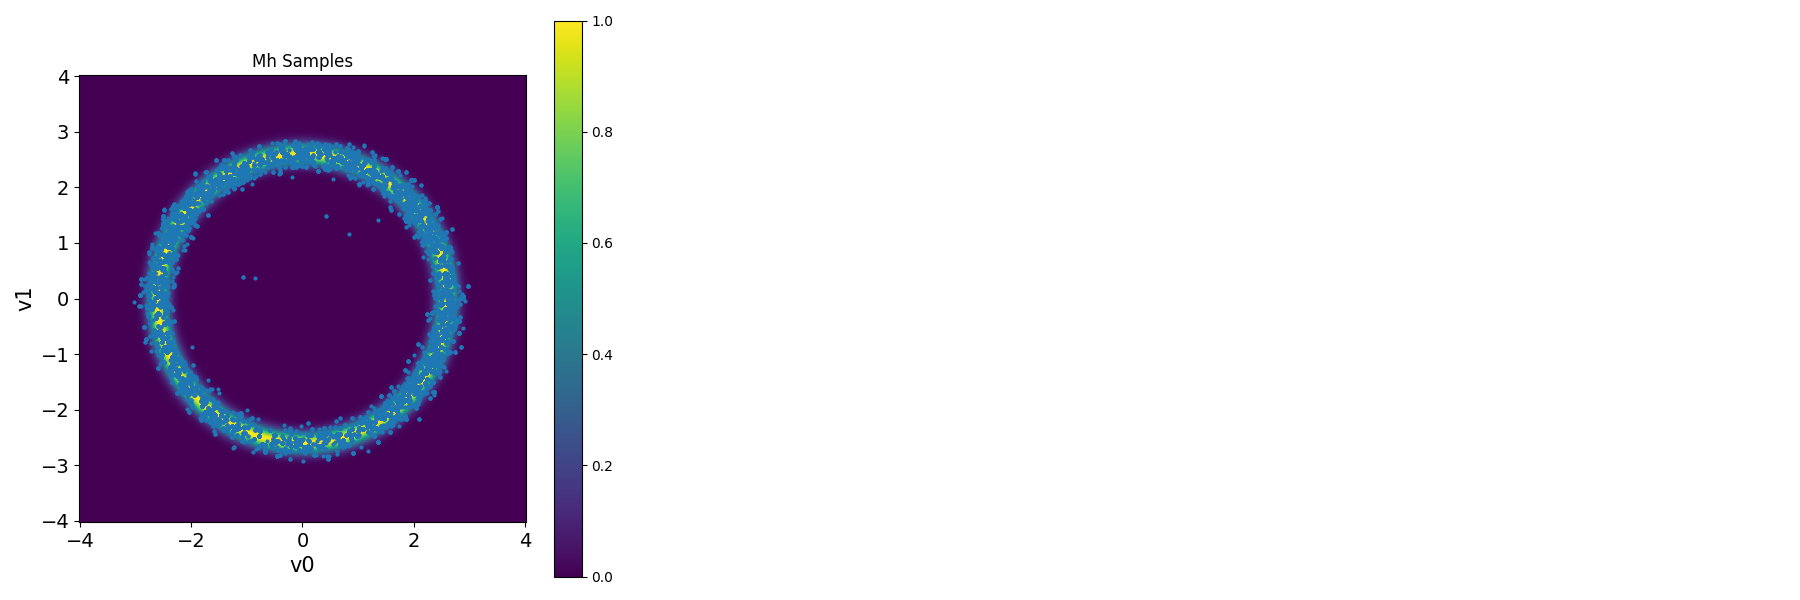

(<Figure size 1800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Mh Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: >, <Axes: >], dtype=object))

In [15]:
s_mh.create_plt()

__CWMH__

In [16]:
s_cwmh = ut.MCMCComparison(target_donut, 1.0, 8500, 1500, x0 = y, seed = 12,chains=2,selected_criteria=["ESS", "AR", "Rhat"], selected_methods= ["CWMH"])

In [17]:
s_cwmh.create_comparison()

/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")
/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")


,CWMH
samples,8500
burnins,1500
scale,1.0
ESS(v0),17.71
ESS(v1),12.823
AR,0.342
Rhat(v0),1.052
Rhat(v1),1.012


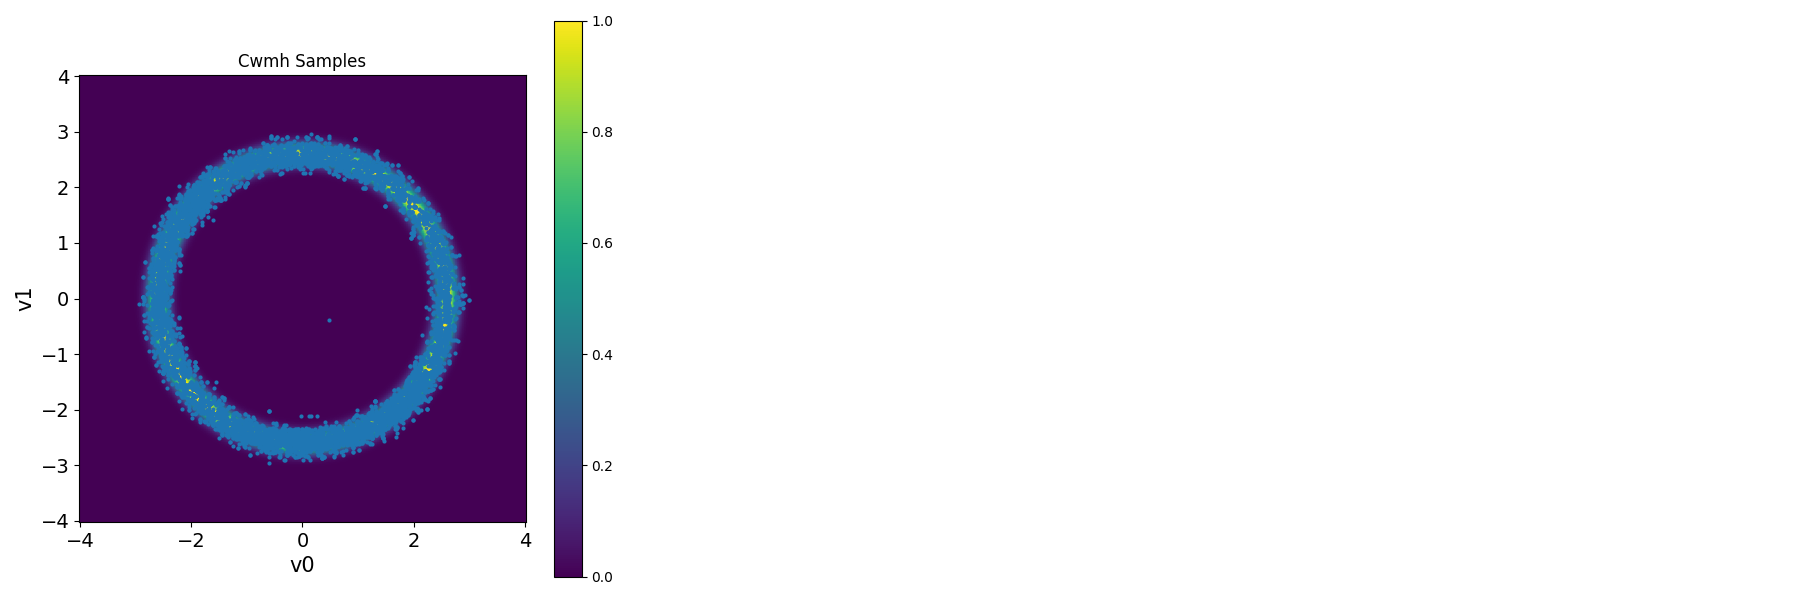

(<Figure size 1800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Cwmh Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: >, <Axes: >], dtype=object))

In [18]:
s_cwmh.create_plt()

__ULA__

In [19]:
s_ula= ut.MCMCComparison(target_donut, 0.055, 8500, 1500, x0 = y, seed = 12,chains=2,  selected_criteria=["ESS", "AR", "Rhat"], selected_methods= ["ULA"])

In [20]:
s_ula.create_comparison()

/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")
/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")


,ULA
samples,8500
burnins,1500
scale,0.055
ESS(v0),30.704
ESS(v1),27.877
AR,1.0
Rhat(v0),1.034
Rhat(v1),1.008


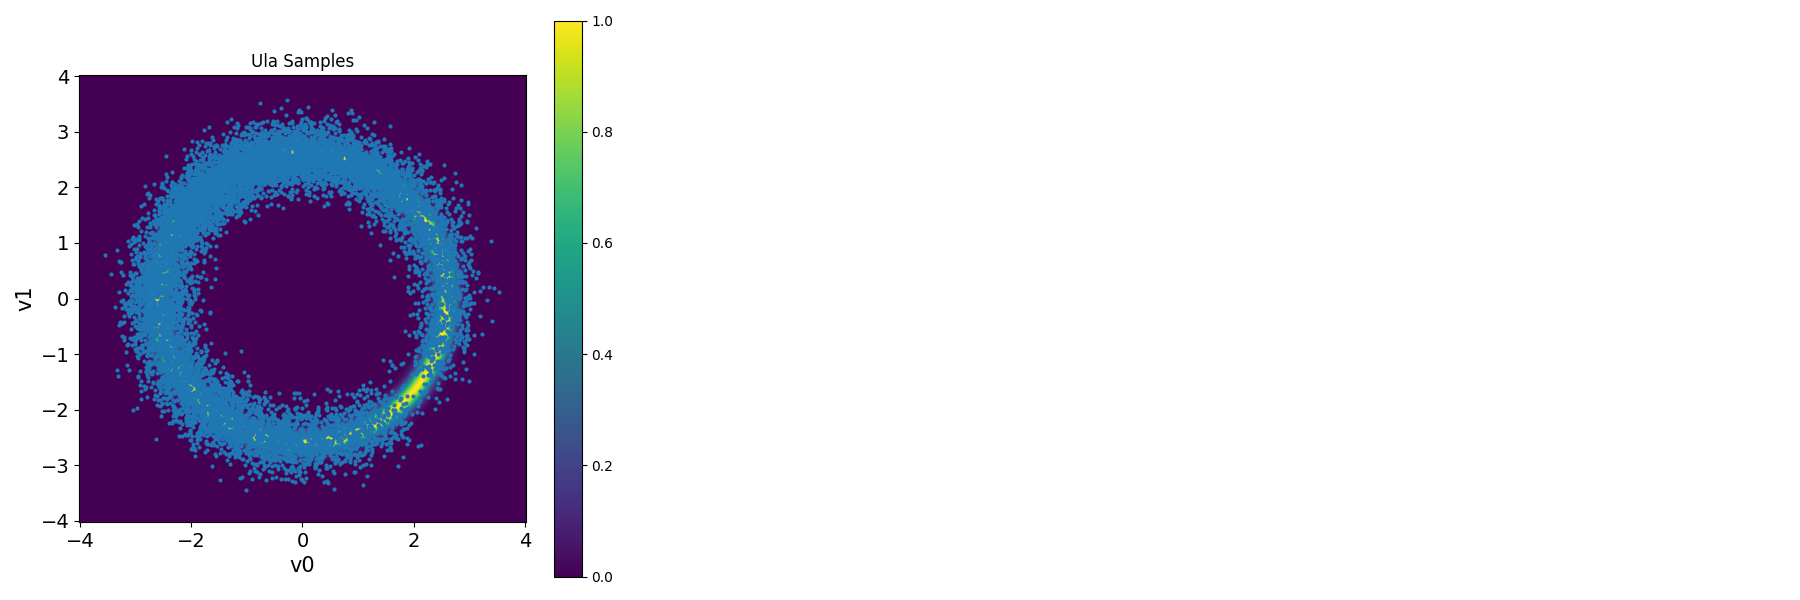

(<Figure size 1800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Ula Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: >, <Axes: >], dtype=object))

In [21]:
s_ula.create_plt()

__MALA__

In [22]:
s_mala = ut.MCMCComparison(target_donut, 0.065, 8500, 1500, x0 = y, seed = 12,chains=2,  selected_criteria=["ESS", "AR", "Rhat"], selected_methods= ["MALA"])

In [23]:
s_mala.create_comparison()

/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")
/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")


,MALA
samples,8500
burnins,1500
scale,0.065
ESS(v0),20.132
ESS(v1),23.288
AR,0.5
Rhat(v0),1.01
Rhat(v1),1.008


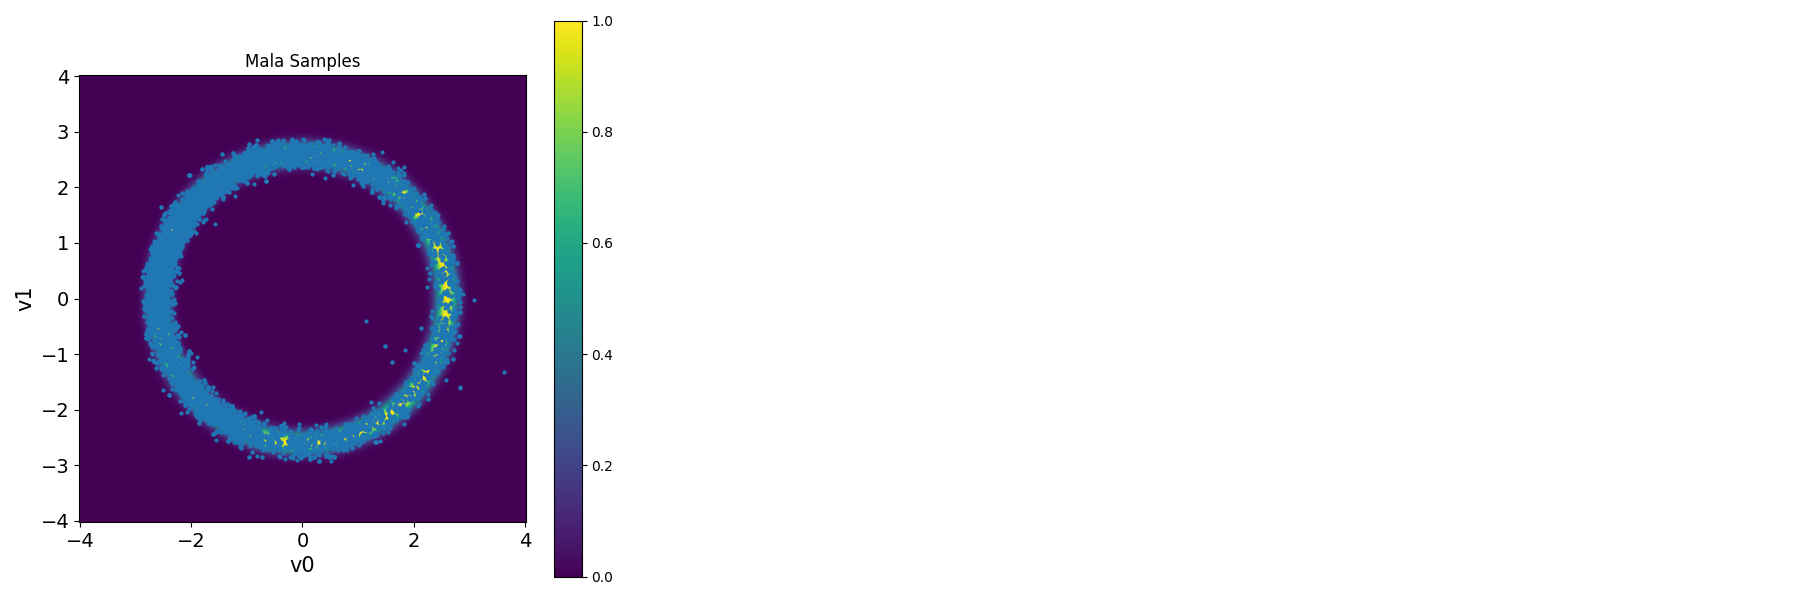

(<Figure size 1800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Mala Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: >, <Axes: >], dtype=object))

In [24]:
s_mala.create_plt()

__NUTS__

In [25]:
s_nuts = ut.MCMCComparison(target_donut, 0.5, 8500, 1500, x0 = y, seed = 12,chains=2, selected_criteria=["ESS", "AR", "Rhat"], selected_methods= ["NUTS"])

In [26]:
s_nuts.create_comparison()

/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")


/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")


,NUTS
samples,8500
burnins,1500
scale,-
ESS(v0),595.306
ESS(v1),623.808
AR,0.624
Rhat(v0),1.0
Rhat(v1),1.003


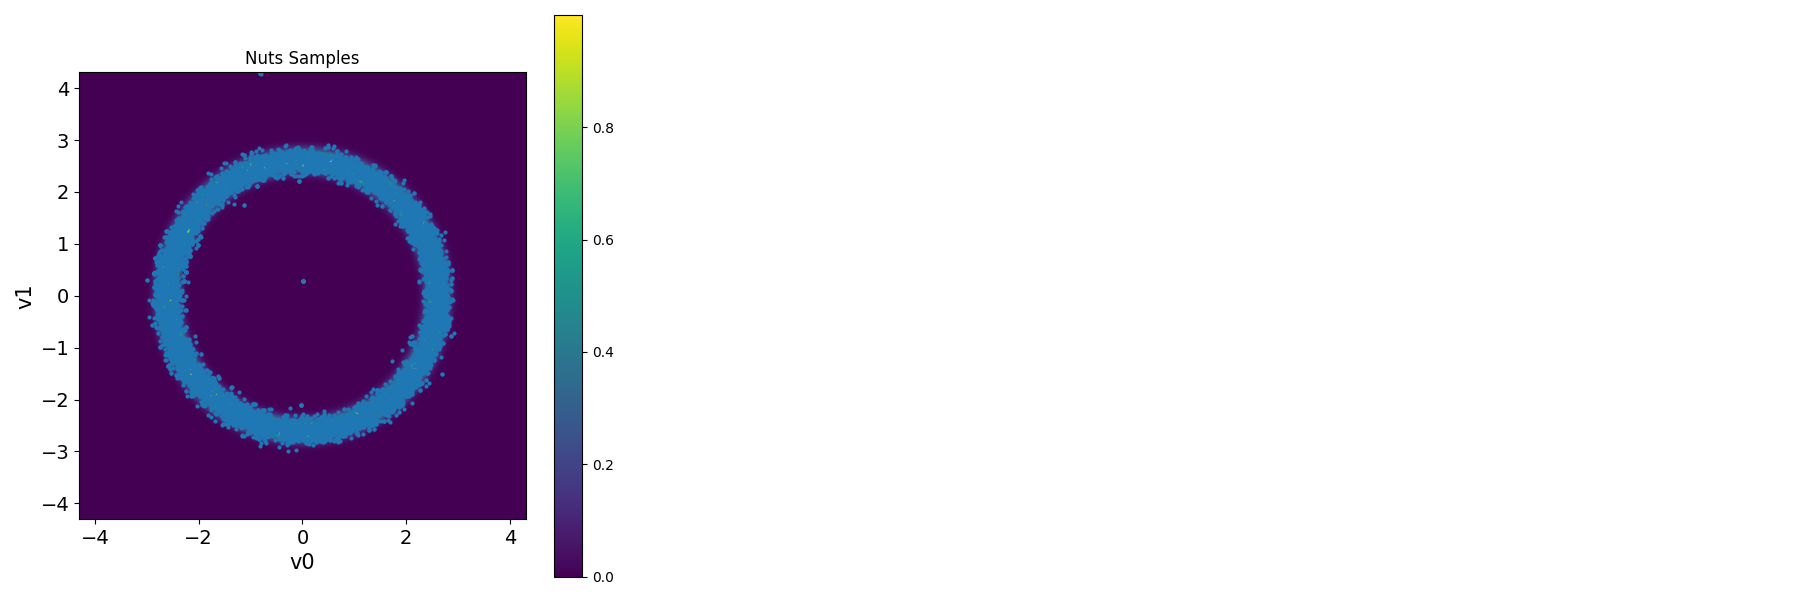

(<Figure size 1800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Nuts Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: >, <Axes: >], dtype=object))

In [27]:
s_nuts.create_plt()

Now, that we have the optimal scale for each method let's take a look at the diagnostics and we are using 4 chains, for a more accurate result. 

In [28]:
samples_tuned = ut.MCMCComparison(target_donut, [0.7, 0.65, 0.055, 0.065, 0.1], 8500, 1500, x0 = y, seed = 12, chains=4)

In [29]:
samples_tuned.create_comparison()

/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")
/opt/conda/envs/env/lib/python3.10/site-packages/cuqi/experimental/mcmc/_sampler.py:13: UserWarning: Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.
  warnings.warn("Module mcmc: Progressbar not found. Install progressbar2 to get sampling progress.")


,MH,CWMH,ULA,MALA,NUTS
samples,8500,8500,8500,8500,8500
burnins,1500,1500,1500,1500,1500
scale,0.7,0.65,0.055,0.065,-
ESS(v0),64.473,4.239,29.81,16.21,21.72
ESS(v1),51.275,30.557,30.052,7.084,18.728
AR,0.224,0.373,1.0,0.502,0.238
LogPDF,10002,20002,10002,10002,58225
Gradient,0,0,10002,10002,58225
Rhat(v0),1.009,1.127,1.025,1.006,1.015
Rhat(v1),1.006,1.0,1.005,1.062,1.003


__Observations__ :
- the most interesting thing is sthat based on Rhat and ESS values ULA is performing better than MALA
- this doesn't really make senese, wespecially when looking at the grph
- however, aafter you realize that ESS and Rhat are all based on convergence and independence, we can understand why this happens. 
This proof that the criteria chosen so far is very subjective, an while it is helpful to determine a good ampling most of the time it can also give errors. 

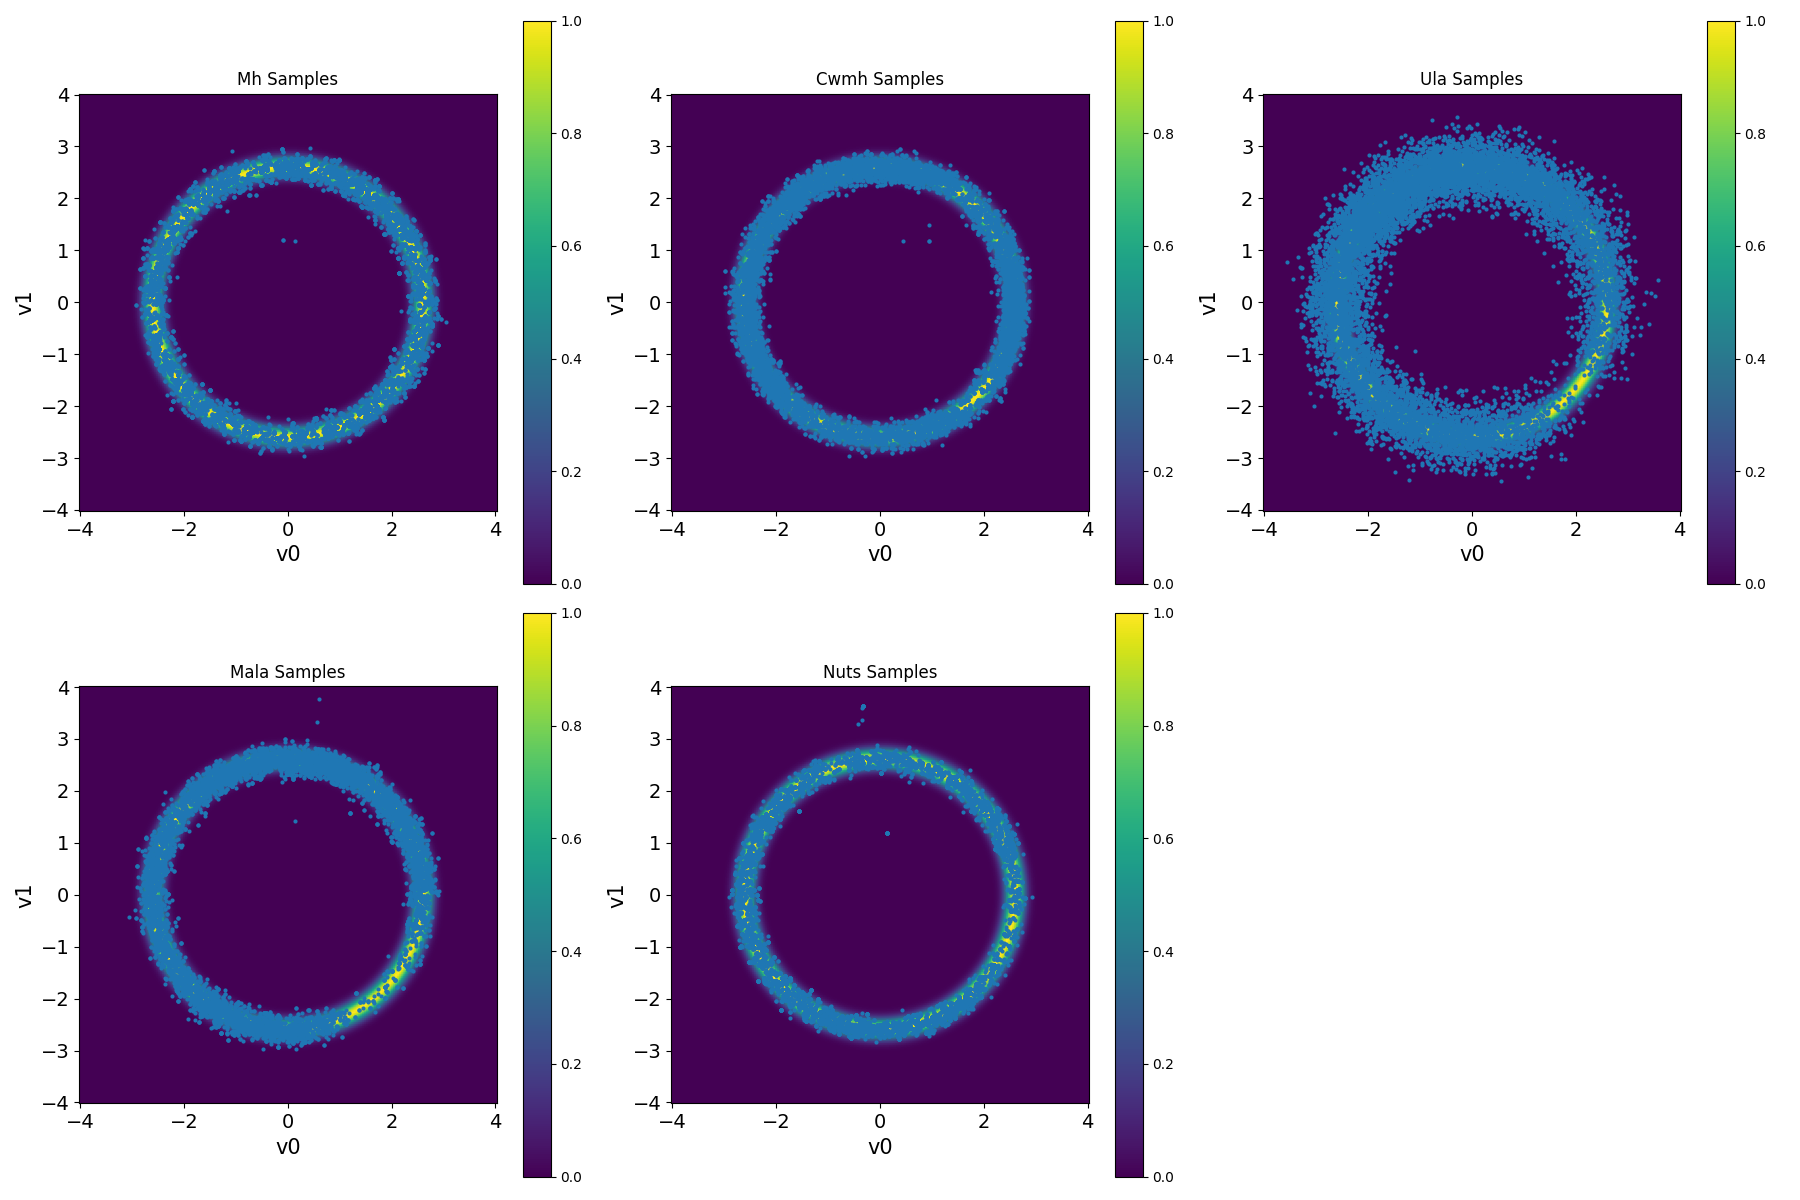

(<Figure size 1800x1200 with 10 Axes>,
 array([<Axes: title={'center': 'Mh Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: title={'center': 'Cwmh Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: title={'center': 'Ula Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: title={'center': 'Mala Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: title={'center': 'Nuts Samples'}, xlabel='v0', ylabel='v1'>,
        <Axes: >], dtype=object))

In [30]:
samples_tuned.create_plt()